### Import dependencies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ps_lib import *

### Load provided Gaussian kernel.

In [2]:
gaussian_kernel = np.load('gaussian-kernel.npy')

### Define helper functions and cross-correlation/convolution function.

In [22]:
def convolution(img, kernel):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    kernel_size = kernel.shape[0]
    pad_amount = int(kernel_size/2)
    gaussian_convolved_img = np.zeros(img.shape)
    for i in range(3):
        zero_padded = pad(img[:,:,i], u_pad=pad_amount, v_pad=pad_amount)
        for r in range(pad_amount, MAX_ROWS+pad_amount):
            for c in range(pad_amount, MAX_COLS+pad_amount):
    #             print("r-pad_amount", r-pad_amount)
    #             print("r-pad_amount+kernel_size", r-pad_amount+kernel_size)
                conv = np.multiply(zero_padded[r-pad_amount:r-pad_amount+kernel_size, c-pad_amount:c-pad_amount+kernel_size],kernel)
                conv = np.sum(conv)
                gaussian_convolved_img[r-pad_amount, c-pad_amount, i] = float(conv)
    return gaussian_convolved_img

In [23]:
def make_one_D_kernel(kernel):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    one_d_gaussian_kernel = kernel
    
    kernel_matrix = np.zeros((MAX_ROWS, MAX_ROWS))
    # print(kernel_matrix.shape)
    for m in range(MAX_ROWS):
    #     print(m)
    #     print(m+(len(one_d_gaussian_kernel)))
    #     print(one_d_gaussian_kernel)
    #     print()
        over = int(len(one_d_gaussian_kernel)/2)
        mid = over
        lower = max(0,m-over)
        upper = min(m+over, MAX_ROWS)
        kernel_lower = mid-over if m-over >= 0 else abs(m-over)
        kernel_upper = mid+over if m+over < MAX_ROWS else (mid+over)-(m+over-MAX_ROWS)
        kernel_matrix[m, lower:upper] = one_d_gaussian_kernel[kernel_lower:kernel_upper]
    return kernel_matrix
    
    

In [24]:
def down_sample(img, factor=2):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    small_img = np.zeros((int(MAX_ROWS/2), int(MAX_COLS/2), 3))
    
    small_img[:,:,0]=resize(image=img[:,:,0], size=[int(MAX_ROWS/2), int(MAX_COLS/2)])
    small_img[:,:,1]=resize(image=img[:,:,1], size=[int(MAX_ROWS/2), int(MAX_COLS/2)])
    small_img[:,:,2]=resize(image=img[:,:,2], size=[int(MAX_ROWS/2), int(MAX_COLS/2)])
    return small_img

In [25]:
def up_sample(img, factor=2):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    small_img = np.zeros((int(MAX_ROWS*2), int(MAX_COLS*2), 3))
    
    small_img[:,:,0]=resize(image=img[:,:,0], size=[int(MAX_ROWS*2), int(MAX_COLS*2)])
    small_img[:,:,1]=resize(image=img[:,:,1], size=[int(MAX_ROWS*2), int(MAX_COLS*2)])
    small_img[:,:,2]=resize(image=img[:,:,2], size=[int(MAX_ROWS*2), int(MAX_COLS*2)])
    return small_img

In [9]:
def one_level_laplacian(img,G):
    # generate Gaussian pyramid for Apple
    A = img.copy()

    # Gaussian blur on Apple
    blurred_A = convolution(A, G)

    # Downsample blurred A
    small_A = down_sample(blurred_A)

    # Upsample small, blurred A
    # insert zeros between pixels, then apply a gaussian low pass filter
    large_A = up_sample(small_A)
    upsampled_A = convolution(large_A, G)

    # generate Laplacian level for A
    laplace_A = A - upsampled_A

    # reconstruct A
#     reconstruct_A = laplace_A + upsampled_A
    
    return small_A, upsampled_A, laplace_A


In [10]:
def F_transform(small_A, G):
    large_A = up_sample(small_A)
    upsampled_A = convolution(large_A, G)
    return upsampled_A

In [13]:
def gamma_decode(img):
    new_img = np.zeros((img.shape))
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            new_img[r,c,0] = np.power(img[r,c,0], 1/1.2)
            new_img[r,c,1] = np.power(img[r,c,1], 1/1.2)
            new_img[r,c,2] = np.power(img[r,c,2], 1/1.2)
    return new_img

## Run Laplacian Pyramid on Apple

In [14]:
img = read_image('apple.png')
img = gamma_decode(img)

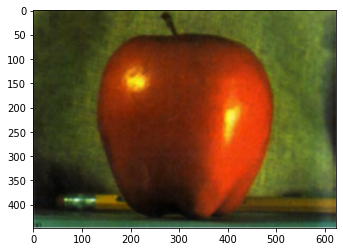

In [15]:
plt.imshow(img)
plt.show()

In [16]:
img.shape

(448, 624, 3)

In [17]:
MAX_ROWS = img.shape[0]
MAX_COLS = img.shape[1]
print("MAX_ROWS = ", MAX_ROWS)
print("MAX_COLS = ", MAX_COLS)

MAX_ROWS =  448
MAX_COLS =  624


In [18]:
G = gaussian_kernel

In [26]:
G = gaussian_kernel
apple_G_small_gaussian_blurred = []
apple_F_upsampled = []
apple_L_laplace = []

# Load Images
apple = read_image('apple.png')
orange = read_image('orange.png')
apple = gamma_decode(apple)
orange = gamma_decode(orange)

img = apple

for i in range(4):
    small_A, upsampled_A, laplace_A = one_level_laplacian(img, G)
    apple_G_small_gaussian_blurred.append(small_A)
    apple_F_upsampled.append(upsampled_A)
    apple_L_laplace.append(laplace_A)
    img = small_A
    

In [27]:
# reconstruct image
apple_reconstructed_imgs = []
start_F = apple_G_small_gaussian_blurred[-1]

for i in reversed(range(0, 4)):
#     print(start_F.shape)
#     print(L_laplace[i].shape)
    reconstructed_F = F_transform(start_F, G) + apple_L_laplace[i]
#     print(reconstructed_F.shape)
    apple_reconstructed_imgs.append(reconstructed_F)
    start_F = reconstructed_F
    

## Run Laplacian Pyramid on Orange

In [28]:

G = gaussian_kernel
orange_G_small_gaussian_blurred = []
orange_F_upsampled = []
orange_L_laplace = []

# # Load Images
# apple = read_image('ps2/apple.png')
# orange = read_image('ps2/orange.png')
# apple = gamma_decode(apple)
# orange = gamma_decode(orange)

img = orange.copy()

for i in range(4):
    small_A, upsampled_A, laplace_A = one_level_laplacian(img, G)
    orange_G_small_gaussian_blurred.append(small_A)
    orange_F_upsampled.append(upsampled_A)
    orange_L_laplace.append(laplace_A)
    img = small_A
    

In [29]:
# reconstruct image
orange_reconstructed_imgs = []
start_F = orange_G_small_gaussian_blurred[-1]

for i in reversed(range(0, 4)):
#     print()
#     print(start_F.shape)
#     print(orange_L_laplace[i].shape)
    reconstructed_F = F_transform(start_F, G) + orange_L_laplace[i]
#     print(reconstructed_F.shape)
    orange_reconstructed_imgs.append(reconstructed_F)
    start_F = reconstructed_F
    

## Run Gaussian Pyramid on Mask.png

In [30]:
mask = read_image('mask.png')

In [31]:
new_mask = np.zeros((orange.shape[0], orange.shape[1]))

In [32]:
ncols = orange.shape[1]

In [33]:
new_mask[:, :int(ncols/2)]=255

In [34]:
mask = new_mask

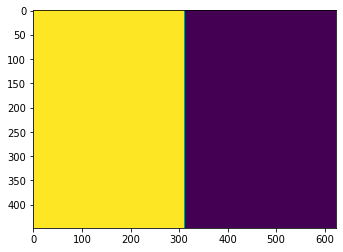

In [35]:
plt.imshow(mask)
plt.show()

In [36]:
mask.shape

(448, 624)

In [37]:
def one_layer_convolution(img, kernel):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    kernel_size = kernel.shape[0]
#     pad_amount = int(kernel_size/2)
    gaussian_convolved_img = np.zeros(img.shape, dtype='uint8')
#     zero_padded = np.pad(img[:,:], pad_amount, pad_with, padder=0)
    for r in range(0, MAX_ROWS):
        for c in range(0, MAX_COLS):
#             print("r-pad_amount", r-pad_amount)
#             print("r-pad_amount+kernel_size", r-pad_amount+kernel_size)
            kernel_r_upper = kernel_size if r+kernel_size < MAX_ROWS else MAX_ROWS-(r+kernel_size)+1
            kernel_c_upper = kernel_size if c+kernel_size < MAX_COLS else MAX_COLS-(c+kernel_size)+1
    
            conv = np.multiply(img[r:r+kernel_size, c:c+kernel_size],kernel[0:kernel_r_upper, 0:kernel_c_upper])
            conv = np.sum(conv)
            gaussian_convolved_img[r, c] = float(conv)
    return gaussian_convolved_img

In [38]:
def one_layer_convolution(img, kernel):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    kernel_size = kernel.shape[0]
#     pad_amount = int(kernel_size/2)
    gaussian_convolved_img = np.zeros(img.shape)
#     zero_padded = np.pad(img[:,:], pad_amount, pad_with, padder=0)
    for r in range(0, MAX_ROWS):
        for c in range(0, MAX_COLS):
#             print("r-pad_amount", r-pad_amount)
#             print("r-pad_amount+kernel_size", r-pad_amount+kernel_size)
            kernel_r_upper = kernel_size if r+kernel_size < MAX_ROWS else MAX_ROWS-(r+kernel_size)+1
            kernel_c_upper = kernel_size if c+kernel_size < MAX_COLS else MAX_COLS-(c+kernel_size)+1
    
            conv = np.multiply(img[r:r+kernel_size, c:c+kernel_size],kernel[0:kernel_r_upper, 0:kernel_c_upper])
            conv = np.sum(conv)
            gaussian_convolved_img[r, c] = float(conv)
    return gaussian_convolved_img

In [39]:
def one_layer_convolution(img, kernel):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    kernel_size = kernel.shape[0]
    #     pad_amount = int(kernel_size/2)
    gaussian_convolved_img = np.zeros(img.shape)
    #     zero_padded = np.pad(img[:,:], pad_amount, pad_with, padder=0)
    for r in range(0, MAX_ROWS):
        for c in range(0, MAX_COLS):
    #             print("r-pad_amount", r-pad_amount)
    #             print("r-pad_amount+kernel_size", r-pad_amount+kernel_size)
            kernel_r_upper = kernel_size if r+kernel_size <= MAX_ROWS else kernel_size-((r+kernel_size)-MAX_ROWS)
            kernel_c_upper = kernel_size if c+kernel_size <= MAX_COLS else kernel_size-((c+kernel_size)-MAX_COLS)
            new_kernel = kernel[0:kernel_r_upper, 0:kernel_c_upper]/np.sum(kernel[0:kernel_r_upper, 0:kernel_c_upper])
            conv = np.multiply(img[r:min(MAX_ROWS,r+kernel_size), c:min(MAX_COLS,c+kernel_size)],new_kernel)
            conv = np.sum(conv)
            gaussian_convolved_img[r, c] = float(conv)
    return gaussian_convolved_img



In [40]:
def one_layer_down_sample(img, factor=2):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    small_img = np.zeros((int(MAX_ROWS/2), int(MAX_COLS/2)))
    
    small_img[:,:]=resize(image=img[:,:], size=[int(MAX_ROWS/2), int(MAX_COLS/2)])
    
    return small_img

In [41]:
def one_level_gaussian_pyramid(img, G):
    # generate Gaussian pyramid for img
    A = img.copy()

    # Gaussian blur on img
    blurred_A = one_layer_convolution(A, G)

    # Downsample blurred A
    small_A = one_layer_down_sample(blurred_A)

    return small_A


In [42]:

G = gaussian_kernel
mask_G_small_gaussian_blurred = [mask]
# F_upsampled = []
# L_laplace = []

# Load Images


img = mask.copy()

for i in range(5):
    small_A = one_level_gaussian_pyramid(img, G)
    mask_G_small_gaussian_blurred.append(small_A)
#     F_upsampled.append(upsampled_A)
#     L_laplace.append(laplace_A)
    img = small_A
    

In [45]:
for i in range(len(mask_G_small_gaussian_blurred)):
    mask_G_small_gaussian_blurred[i] = mask_G_small_gaussian_blurred[i]/np.max(mask_G_small_gaussian_blurred[i])
    
    

In [46]:
np.max(mask_G_small_gaussian_blurred[-1])

1.0

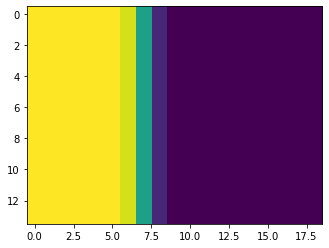

In [47]:
plt.imshow(mask_G_small_gaussian_blurred[-1])

## Time for Laplacian blending!

In [42]:
# orange_G_small_gaussian_blurred = []
# orange_F_upsampled = []
# orange_L_laplace = []

In [48]:
for i in mask_G_small_gaussian_blurred:
    print(i.shape)

(448, 624)
(224, 312)
(112, 156)
(56, 78)
(28, 39)
(14, 19)


In [49]:
for i in orange_G_small_gaussian_blurred:
    print(i.shape)

(224, 312, 3)
(112, 156, 3)
(56, 78, 3)
(28, 39, 3)


In [50]:
for i in orange_L_laplace:
    print(i.shape)

(448, 624, 3)
(224, 312, 3)
(112, 156, 3)
(56, 78, 3)


In [52]:
mask_apple_1d = mask_G_small_gaussian_blurred[-2]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[-2]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)

G_c = apple_G_small_gaussian_blurred[-1]*mask_apple + \
        orange_G_small_gaussian_blurred[-1]*mask_orange

In [53]:
F_1 = up_sample(G_c)
upsampled_F1 = convolution(F_1, G)

In [54]:
mask_apple_1d = mask_G_small_gaussian_blurred[-3]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[-3]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)

In [55]:
L_a = apple_L_laplace[-1]
L_o = orange_L_laplace[-1]

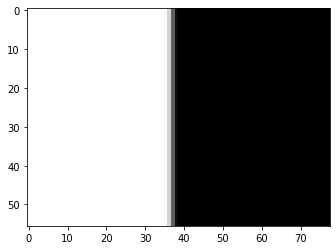

In [70]:
plt.imshow(mask_apple)

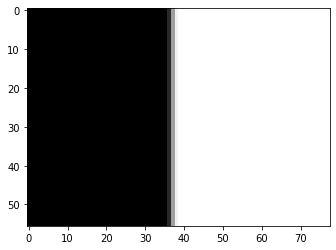

In [71]:
plt.imshow(mask_orange)

In [77]:
L_c = (mask_apple * L_a) + (mask_orange * L_o)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


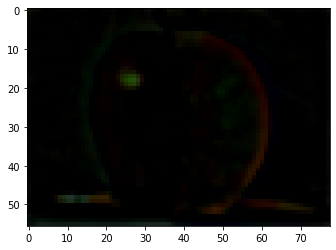

In [78]:
plt.imshow(L_c)

In [79]:
F_2 = L_c + upsampled_F1

In [80]:
upsampled_F1.shape

(56, 78, 3)

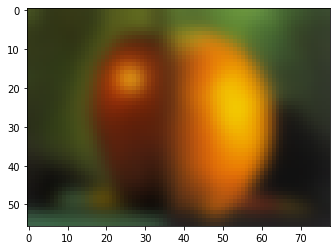

In [81]:
F1_plot = np.array(upsampled_F1)
plt.imshow(F1_plot)

In [82]:
new_L_c = L_c + (1-L_c)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


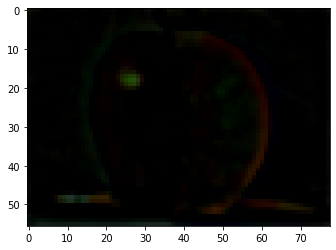

In [83]:
plt.imshow(L_c)

In [84]:
F_2 = L_c + upsampled_F1

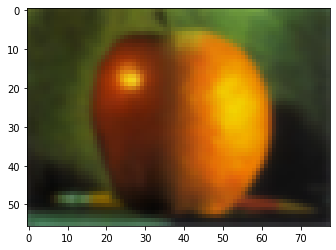

In [85]:
F2_plot = np.array(F_2)
plt.imshow(F2_plot)

In [100]:

reconstructed_imgs = []
mask_apple_1d = mask_G_small_gaussian_blurred[4]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[4]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)

G_c = apple_G_small_gaussian_blurred[3]*mask_apple + \
        orange_G_small_gaussian_blurred[3]*mask_orange

F_1 = up_sample(G_c)
upsampled_F1 = convolution(F_1, G)

mask_apple_1d = mask_G_small_gaussian_blurred[3]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[3]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)

L_a = apple_L_laplace[3]
L_o = orange_L_laplace[3]

L_c = (mask_apple * L_a) + (mask_orange * L_o)
F_2 = L_c + upsampled_F1
reconstructed_imgs.append(F_2)

In [101]:
# F_1 = F_2
F_1 = up_sample(F_2)
upsampled_F1 = convolution(F_1, G)

mask_apple_1d = mask_G_small_gaussian_blurred[2]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[2]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)
print(mask_apple.shape)

L_a = apple_L_laplace[2]
L_o = orange_L_laplace[2]

L_c = (mask_apple * L_a) + (mask_orange * L_o)
print(upsampled_F1.shape)
F_2 = L_c + upsampled_F1
reconstructed_imgs.append(F_2)

(112, 156, 3)
(112, 156, 3)


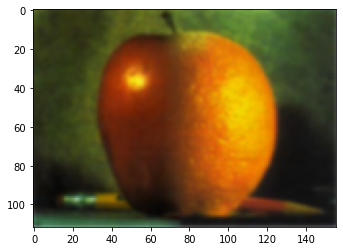

In [102]:
plt.imshow(F_2)

In [103]:
# F_1 = F_2
F_1 = up_sample(F_2)
upsampled_F1 = convolution(F_1, G)

mask_apple_1d = mask_G_small_gaussian_blurred[1]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[1]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)
print(mask_apple.shape)

L_a = apple_L_laplace[1]
L_o = orange_L_laplace[1]

L_c = (mask_apple * L_a) + (mask_orange * L_o)
print(upsampled_F1.shape)
F_2 = L_c + upsampled_F1
reconstructed_imgs.append(F_2)

(224, 312, 3)
(224, 312, 3)


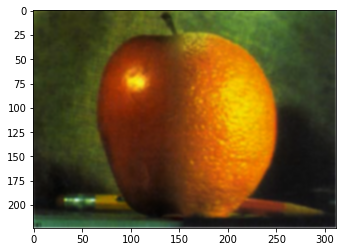

In [104]:
plt.imshow(F_2)

In [105]:
# F_1 = F_2
F_1 = up_sample(F_2)
upsampled_F1 = convolution(F_1, G)

mask_apple_1d = mask_G_small_gaussian_blurred[0]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[0]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)
print(mask_apple.shape)

L_a = apple_L_laplace[0]
L_o = orange_L_laplace[0]

L_c = (mask_apple * L_a) + (mask_orange * L_o)
print(upsampled_F1.shape)
F_2 = L_c + upsampled_F1
reconstructed_imgs.append(F_2)

(448, 624, 3)
(448, 624, 3)


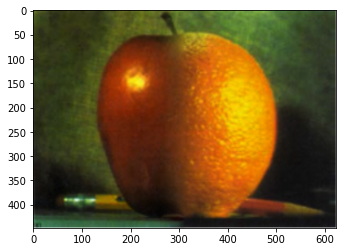

In [106]:
plt.imshow(F_2)

In [107]:
write_image(path='q3-apple-and-orange.png', image=F_2)